In [2]:
# importing packages
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# font size
sns.set_style("white", rc={"font_scale": 1.5})

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest
from CP2LFI.scores import LambdaScore

from clover import Scores
from clover import LocartSplit

from copy import deepcopy
from tqdm import tqdm

from scipy import stats
from scipy.optimize import minimize_scalar

import time

\section{Comparing our methods for a BFF example with normal distribution}
Taking $\theta \in \Theta = [-5,5]$ we consider a one-dimensional normal prior over $\theta$ given by:
\begin{align*}
\theta \sim N(0, 0.25) ,
\end{align*}
with the likelihood of X given by:
\begin{align*}
X \sim N(\theta, 1).
\end{align*}
In this case, we obtain the $1 - \alpha$ credibility region of $\theta$ by obtaining $C_{\theta}$ such that:
\begin{align*}
\mathbb{P}(\{\theta: f(\theta|x) \geq C_{\theta}\}) = 1 - \alpha .
\end{align*}

Now we define the main functions to simulate all samples and compute naive quantiles:

In [3]:
def sim_X(n, theta, rng):
    X = rng.normal(theta, 1, n)
    return X


def sim_lambda(B, N, theta, rng, sigma=0.25):
    lambdas = np.zeros(B)
    for i in range(0, B):
        X = sim_X(N, theta, rng = rng)
        lambdas[i] = compute_pdf_posterior(theta, X, sigma=sigma)
    return lambdas


def sample_posterior(n, N, rng, sigma=0.25):
    thetas = rng.uniform(-5, 5, size=n)
    lambdas = np.zeros(n)
    i = 0
    for theta in thetas:
        X = sim_X(N, theta, rng = rng)
        lambdas[i] = compute_pdf_posterior(theta, X, sigma=sigma)
        i += 1
    return thetas, lambdas


def compute_pdf_posterior(theta, x, sigma=0.25):
    n = x.shape[0]
    mu_value = (1 / ((1 / sigma) + n)) * (np.sum(x))
    sigma_value = ((1 / sigma) + n) ** (-1)
    return -stats.norm.pdf(theta, loc=mu_value, scale=np.sqrt(sigma_value))


# naive method
def naive(alpha, rng, B=1000, N=100, lower=-5, upper=5, naive_n=100, sigma=0.25):
    n_grid = int(B / naive_n)
    thetas = np.linspace(lower, upper, n_grid)
    quantiles = {}
    for theta in thetas:
        lambdas = sim_lambda(B=naive_n, N=N, theta=theta, sigma=sigma, rng = rng)
        quantiles[theta] = np.quantile(lambdas, q=1 - alpha)
    return quantiles


# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
        quantiles_list.append(quantiles_dict[idx])
    return quantiles_list

Lets also check if the statistics are not invariant:

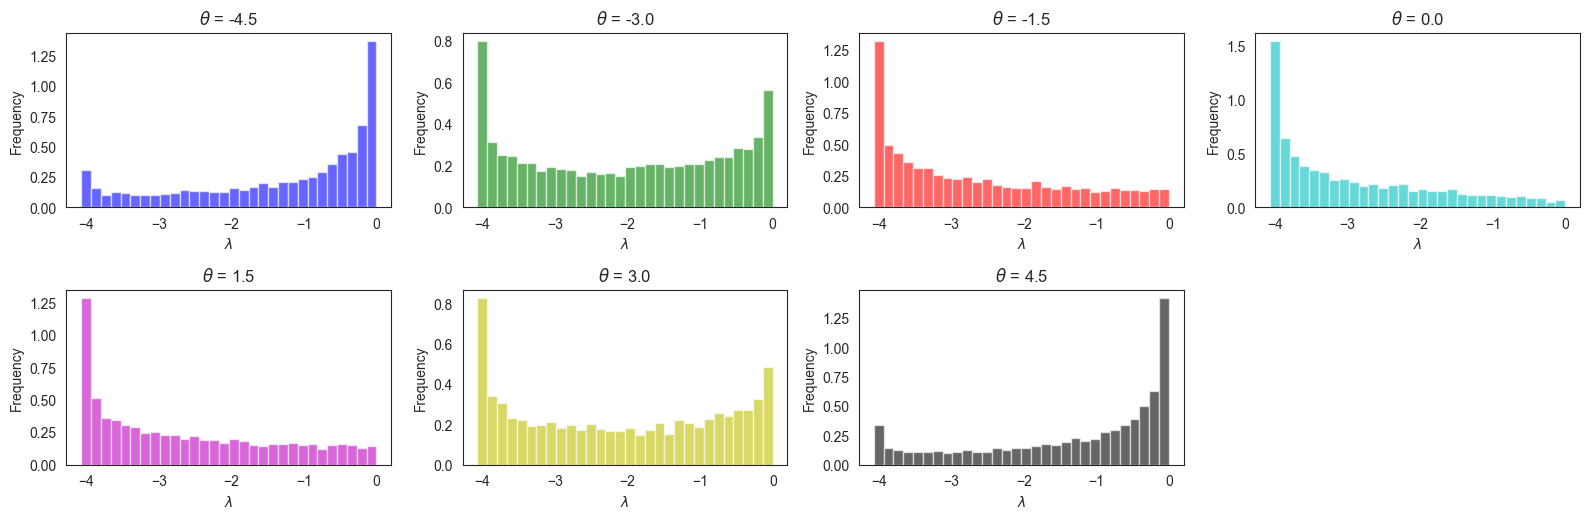

In [4]:
#| echo: false
rng = np.random.default_rng(125)
theta_vec = np.array([-4.5, -3, -1.5, 0, 1.5, 3, 4.5])
simulations = [sim_lambda(B = 5000, N = 100, theta = theta, rng = rng) for theta in theta_vec]

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Define a list of colors
num_columns = 4  # 

# Calculate the number of rows needed for the subplots
num_rows = len(simulations) // num_columns
num_rows += len(simulations) % num_columns

# Reshape the subplot grid to accommodate all simulations
fig, axs = plt.subplots(num_rows, num_columns, figsize=(16, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i, simulation in enumerate(simulations):
    lambdas = simulation
    axs[i].hist(lambdas, bins=30, density=True, alpha=0.6, color=colors[i % len(colors)])  # Use different color for each histogram
    axs[i].set_title(r'$\theta$ = {}'.format(theta_vec[i]))
    axs[i].set_xlabel(r'$\lambda$')
    axs[i].set_ylabel('Frequency')

# Remove unused subplots
if len(simulations) < len(axs):
    for i in range(len(simulations), len(axs)):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

As we saw, the statistics appear to have different distributions as we change $\theta$ values. Lets now compare our methods to all the others for several N:


In [5]:
# function to obtain all comparing methods quantile
def obtain_quantiles(
    thetas,
    N,
    rng,
    B=1000,
    alpha=0.05,
    min_samples_leaf=100,
    n_estimators = 100,
    K = 40,
    naive_n=500,
    sigma=0.25,
):
    # fixing seed
    # fitting and predicting naive
    naive_quantiles = naive(
        alpha=alpha, B=B, N=N, naive_n=naive_n, sigma=sigma, rng = rng
    )
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # simulating to fit models
    theta_sim, model_lambdas = sample_posterior(n=B, N=N, rng = rng)
    model_thetas = theta_sim.reshape(-1, 1)

    locart_object = LocartSplit(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    locart_quantiles = locart_object.calib(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf
    )

    # loforest quantiles
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    loforest_object.calibrate(
        model_thetas, 
        model_lambdas, 
        min_samples_leaf=min_samples_leaf, 
        n_estimators = n_estimators,
        K = K,
    )

    # boosting quantiles
    model = HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile=1 - alpha,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
    model.fit(model_thetas, model_lambdas)

    # naive quantiles
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # locart quantiles
    idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
    list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))

    # boosting
    boosting_quantiles = model.predict(thetas.reshape(-1, 1))

    # dictionary of quantiles
    quantile_dict = {
        "naive": naive_list,
        "locart": list_locart_quantiles,
        "loforest": loforest_cutoffs,
        "boosting": boosting_quantiles,
    }

    return quantile_dict


# evaluate coverage for several N's and B = 1000
def evaluate_coverage_N(
    thetas,
    N=np.array([10, 100, 1000]),
    B=1000,
    alpha=0.05,
    n=1000,
    seed=45,
    min_samples_leaf=100,
    n_estimators = 100,
    K = 40,
    naive_n=100,
    sigma=0.25,
):
    coverage_data = np.zeros((thetas.shape[0] * N.shape[0], 4))
    N_list = []
    N_list_cover = []
    methods_list = []
    rng = np.random.default_rng(seed)
    k = 0
    j = 0
    for N_fixed in tqdm(N, desc="Computing coverage for each N"):
        # computing all quantiles for fixed N
        quantiles_dict = obtain_quantiles(
            thetas,
            N=N_fixed,
            B=B,
            alpha=alpha,
            min_samples_leaf=min_samples_leaf,
            naive_n=naive_n,
            sigma=sigma,
            rng = rng,
            n_estimators = n_estimators,
            K = K
        )
        err_data = np.zeros((thetas.shape[0], 4))
        l = 0
        for theta in tqdm(thetas, desc="Computing coverage for each method"):
            # generating several lambdas
            lambda_stat = sim_lambda(B=n, N=N_fixed, theta=theta, sigma=sigma, rng = rng)

            # comparing coverage of methods
            locart_cover = np.mean(lambda_stat <= quantiles_dict["locart"][l])
            loforest_cover = np.mean(lambda_stat <= quantiles_dict["loforest"][l])
            boosting_cover = np.mean(lambda_stat <= quantiles_dict["boosting"][l])
            naive_cover = np.mean(lambda_stat <= quantiles_dict["naive"][l])

            # appending the errors
            err_locart = np.abs(locart_cover - (1 - alpha))
            err_loforest = np.abs(loforest_cover - (1 - alpha))
            err_boosting = np.abs(boosting_cover - (1 - alpha))
            err_naive = np.abs(naive_cover - (1 - alpha))

            # saving in numpy array
            err_data[l, :] = np.array(
                [err_locart, err_loforest, err_boosting, err_naive]
            )

            coverage_data[j, :] = np.array(
                [locart_cover, loforest_cover, boosting_cover, naive_cover]
            )
            N_list_cover.append(N_fixed)

            j += 1
            l += 1
        methods_list.extend(["LOCART", "LOFOREST", "boosting", "naive"])
        if k == 0:
            mae_vector = np.mean(err_data, axis=0)
            std_vector = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
        else:
            mean = np.mean(err_data, axis=0)
            std = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
            mae_vector, std_vector = np.concatenate((mae_vector, mean)), np.concatenate(
                (std_vector, std)
            )
        k += 1
        N_list.extend([N_fixed] * 4)

    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "MAE": mae_vector,
            "se": std_vector,
        }
    )

    coverage_data = pd.DataFrame(
        {
            "thetas": np.tile(thetas, N.shape[0]),
            "N": N_list_cover,
            "LOCART": coverage_data[:, 0],
            "LOFOREST": coverage_data[:, 1],
            "boosting": coverage_data[:, 2],
            "naive": coverage_data[:, 3],
        }
    )
    return [stats_data, coverage_data]

Testing for $B = 5000$:

In [10]:
# | output: false
n_out = 750
thetas = np.linspace(-4.999, 4.999, n_out)

coverage_data_N_5000 = evaluate_coverage_N(
    thetas,
    N=np.array([10, 100, 1000, 2000]),
    B=5000,
    naive_n=500,
    min_samples_leaf=300,
    n=2000,
    seed=1250,
)

Computing coverage for each N: 100%|██████████| 4/4 [07:04<00:00, 106.15s/it]


Plotting all results:

/tmp/ipykernel_26661/2486645017.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  a.set_xticklabels(a.get_xticklabels(), rotation=90)


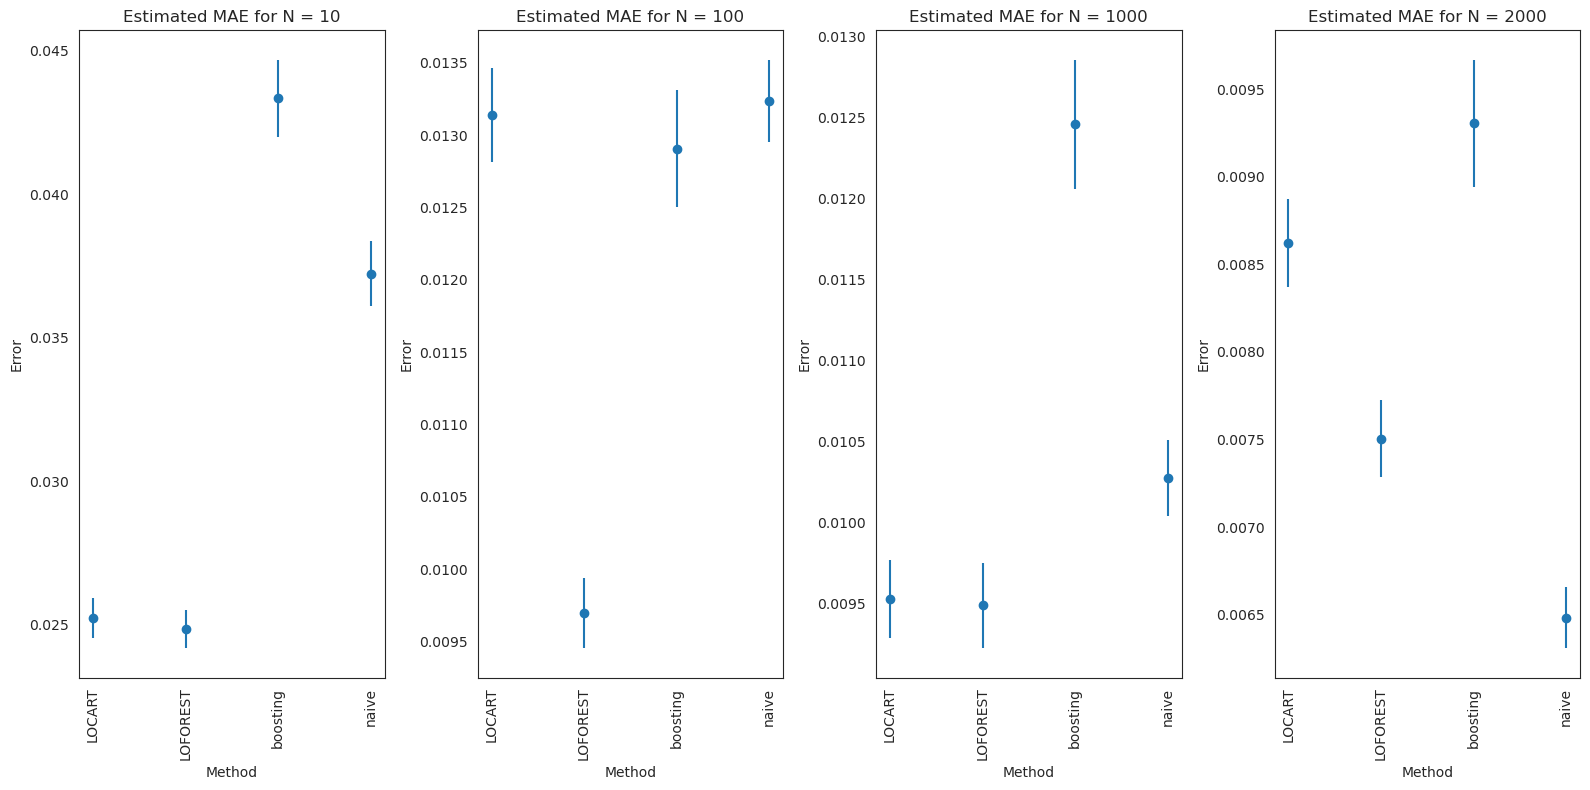

In [11]:
# | echo: false
fig, ax = plt.subplots(ncols=4, figsize=(16, 8))
# data for first subplot
data_10 = coverage_data_N_5000[0].query("N == 10")
keys = data_10.iloc[:, 0].values
mae = data_10.iloc[:, 2].values
std_err = data_10.iloc[:, 3].values
ax[0].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[0].set_xlabel("Method")
ax[0].set_ylabel("Error")
ax[0].set_title("Estimated MAE for N = 10")


data_100 = coverage_data_N_5000[0].query("N == 100")
keys = data_100.iloc[:, 0].values
mae = data_100.iloc[:, 2].values
std_err = data_100.iloc[:, 3].values
ax[1].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[1].set_xlabel("Method")
ax[1].set_ylabel("Error")
ax[1].set_title("Estimated MAE for N = 100")


data_1000 = coverage_data_N_5000[0].query("N == 1000")
keys = data_1000.iloc[:, 0].values
mae = data_1000.iloc[:, 2].values
std_err = data_1000.iloc[:, 3].values
ax[2].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[2].set_xlabel("Method")
ax[2].set_ylabel("Error")
ax[2].set_title("Estimated MAE for N = 1000")

data_2000 = coverage_data_N_5000[0].query("N == 2000")
keys = data_2000.iloc[:, 0].values
mae = data_2000.iloc[:, 2].values
std_err = data_2000.iloc[:, 3].values
ax[3].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[3].set_xlabel("Method")
ax[3].set_ylabel("Error")
ax[3].set_title("Estimated MAE for N = 2000")

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_26661/3040260134.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


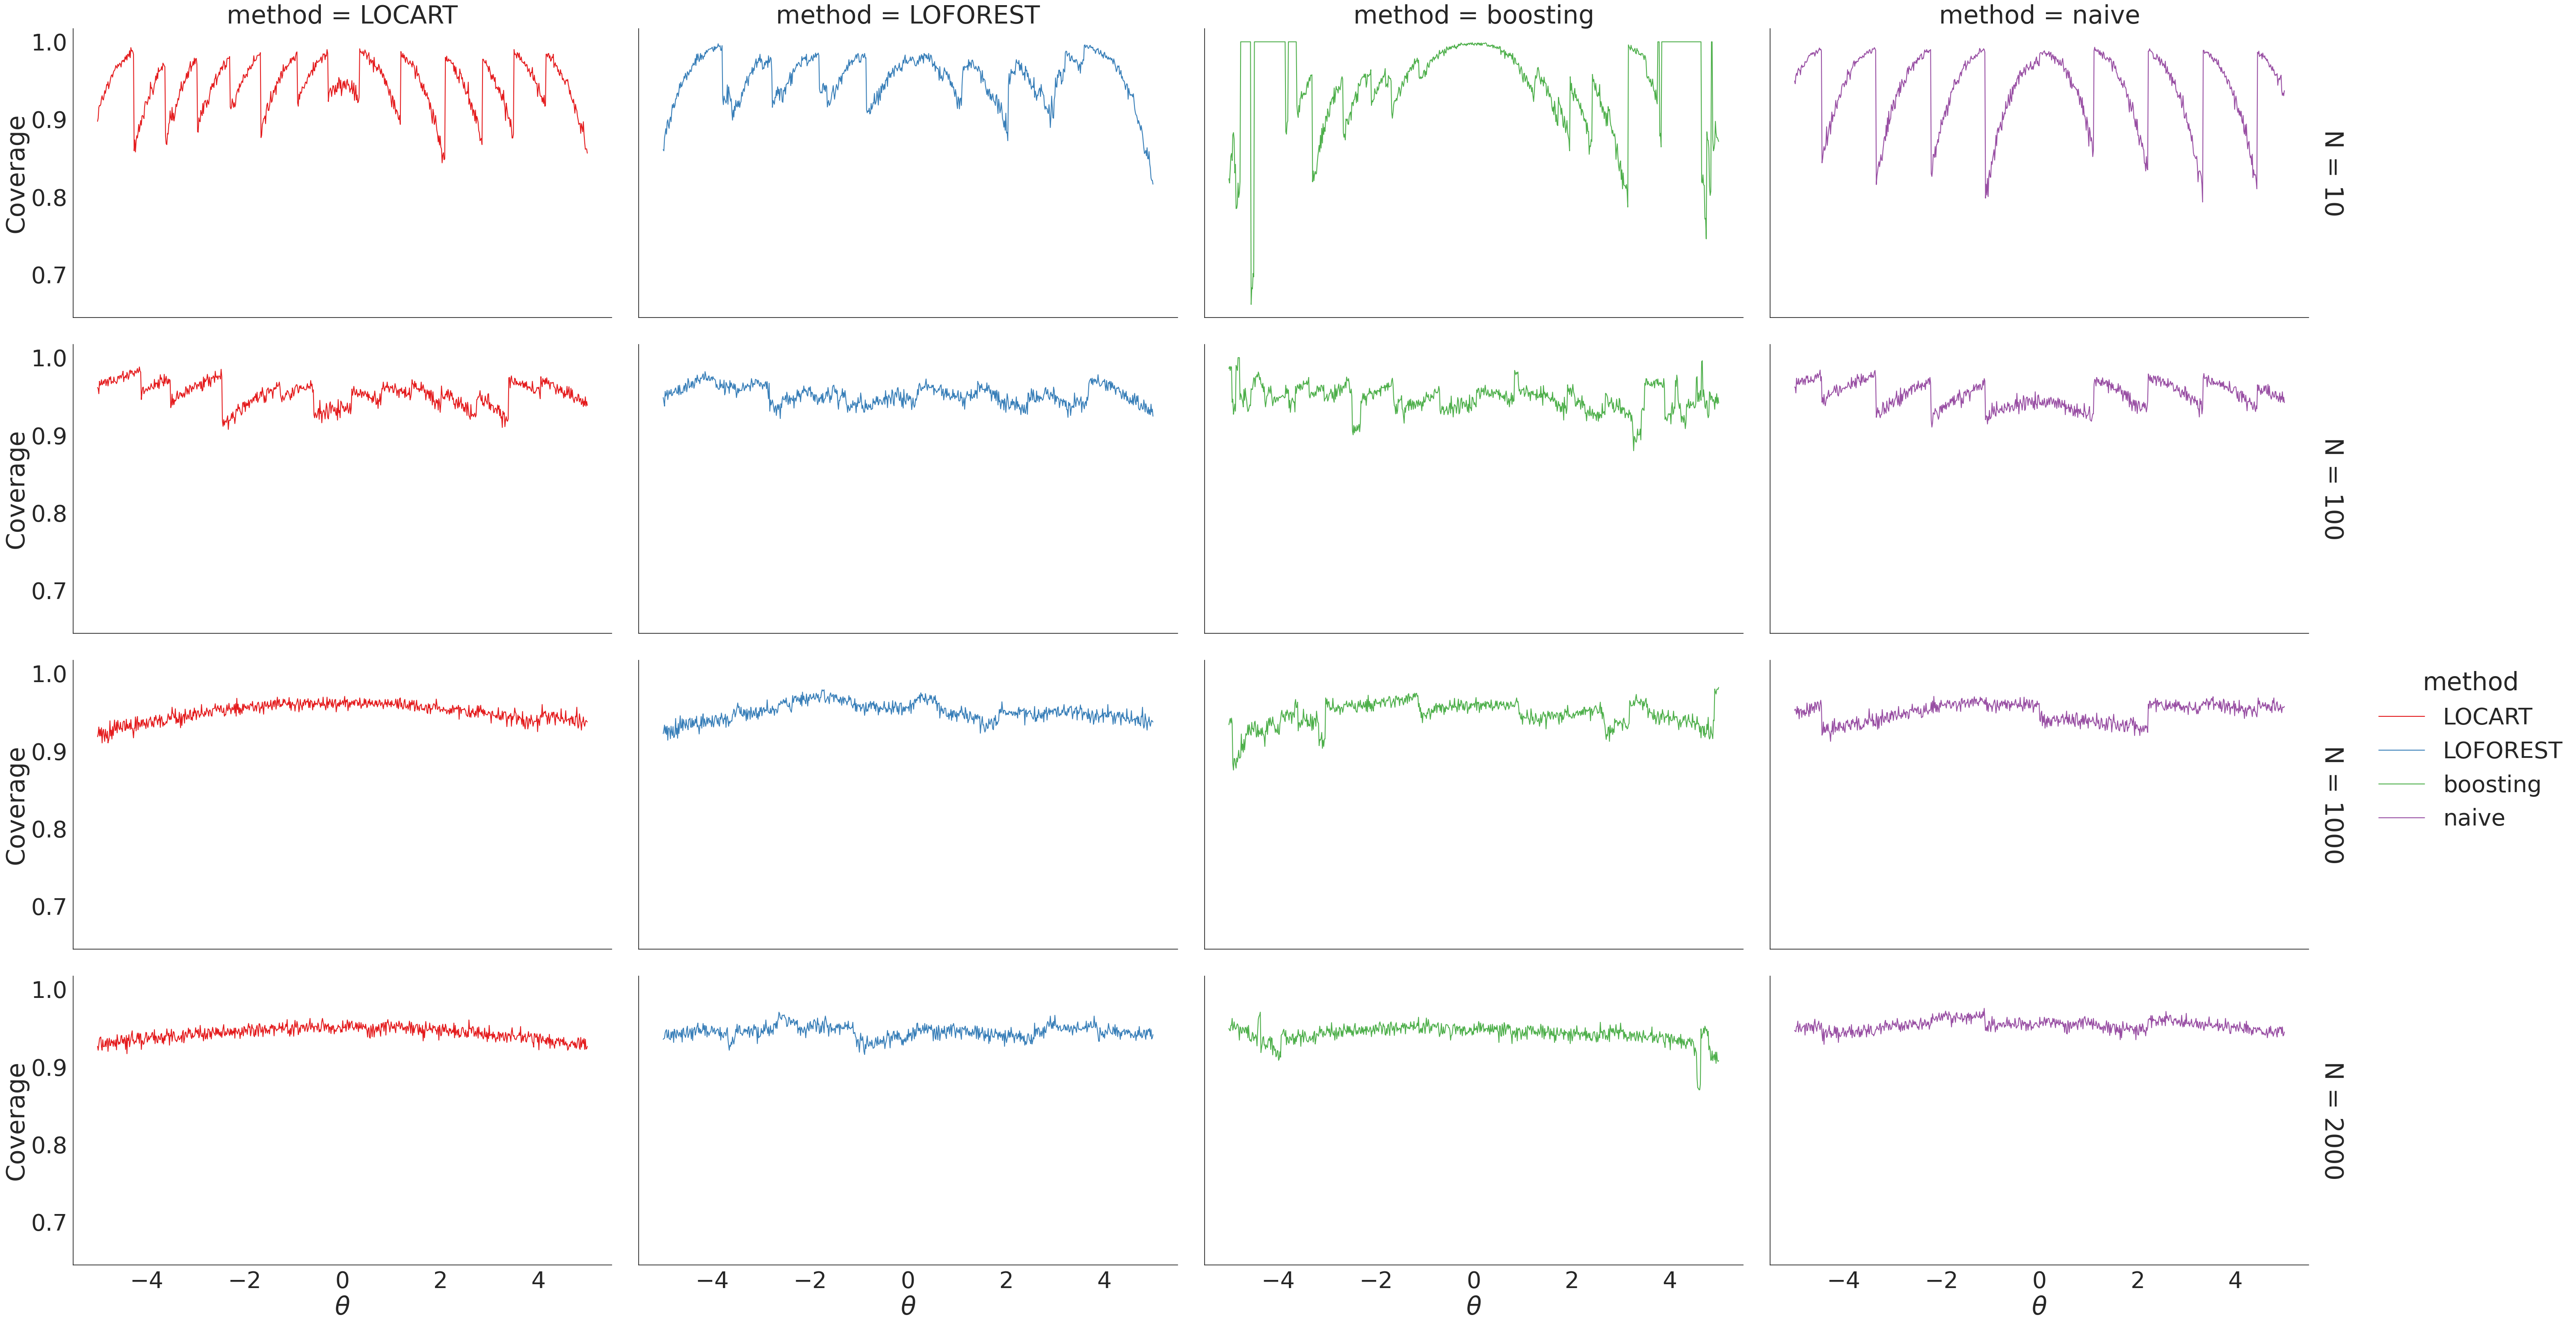

In [12]:
# | echo: false
# plotting coverage
coverage_data_melted = pd.melt(
    coverage_data_N_5000[1],
    id_vars=["thetas", "N"],
    var_name="method",
    value_name="coverage",
)
# Plot the coverage as function of the thetas generated
sns.set(style="white", font_scale=3.5)
g = sns.FacetGrid(
    coverage_data_melted,
    row="N",
    col="method",
    hue="method",
    height=8,
    aspect=1.60,
    palette="Set1",
    margin_titles=True,
)
g.map(sns.lineplot, "thetas", "coverage")
g.add_legend(bbox_to_anchor=(1., 0.5), loc=2, borderaxespad=0.)
g.set_titles("{col_name}")
g.set_xlabels(r"$\theta$")
g.set_ylabels("Coverage")
plt.tight_layout()
plt.show()

Now, lets evaluate the performance of each method as a function of the sample size $B$ for several $N$, in this case $N \in \{1, 50, 100, 1000\}$ and $B \in \{500, 1000, 5000, 10000\}$:

In [16]:
# function to compute MAE stats for several B's and N's
def compute_MAE_N(
    thetas,
    N=np.array([1, 10, 100, 1000]),
    B=np.array([500, 1000, 5000, 10000, 15000, 20000]),
    alpha=0.05,
    n=1000,
    seed=45,
    min_samples_leaf=100,
    n_estimators = 100,
    K = 40,
    naive_n=100,
    sigma=0.25,
):
    N_list = []
    mae_list = []
    se_list = []
    methods_list = []
    B_list = []
    j = 0
    rng = np.random.default_rng(seed)
    for N_fixed in tqdm(N, desc="Computing coverage for each N"):
        k = 0
        for B_fixed in B:
            # computing all quantiles for fixed N
            quantiles_dict = obtain_quantiles(
                thetas,
                N=N_fixed,
                B=B_fixed,
                alpha=alpha,
                min_samples_leaf=min_samples_leaf,
                naive_n=naive_n,
                sigma=sigma,
                rng = rng,
                n_estimators = n_estimators,
                K = K,
            )
            err_data = np.zeros((thetas.shape[0], 4))
            l = 0
            for theta in thetas:
                # generating several lambdas
                lambda_stat = sim_lambda(
                    B=n,
                    N=N_fixed,
                    theta=theta,
                    sigma=sigma,
                    rng = rng,
                )

                # comparing coverage of methods
                locart_cover = np.mean(lambda_stat <= quantiles_dict["locart"][l])
                loforest_cover = np.mean(lambda_stat <= quantiles_dict["loforest"][l])
                boosting_cover = np.mean(lambda_stat <= quantiles_dict["boosting"][l])
                naive_cover = np.mean(lambda_stat <= quantiles_dict["naive"][l])

                # appending the errors
                err_locart = np.abs(locart_cover - (1 - alpha))
                err_loforest = np.abs(loforest_cover - (1 - alpha))
                err_boosting = np.abs(boosting_cover - (1 - alpha))
                err_naive = np.abs(naive_cover - (1 - alpha))

                # saving in numpy array
                err_data[l, :] = np.array(
                    [err_locart, err_loforest, err_boosting, err_naive]
                )

                l += 1
            
            mae_list.extend(np.mean(err_data, axis = 0).tolist())
            se_list.extend((np.std(err_data, axis = 0)/np.sqrt(thetas.shape[0])).tolist())
            methods_list.extend(["LOCART", "LOFOREST", "boosting", "naive"])
            N_list.extend([N_fixed] * 4)
            B_list.extend([B_fixed] * 4)


    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

In [22]:
# | output: false
n_out = 500
thetas = np.linspace(-4.999, 4.999, n_out)
mae_stats = compute_MAE_N(
    thetas,
    N=np.array([1, 50, 100, 500, 1000, 2000]),
    naive_n=500,
    min_samples_leaf=300,
    n_estimators = 200,
    K = 50,
    seed=45,
)

Computing coverage for each N: 100%|██████████| 6/6 [21:43<00:00, 217.22s/it]


Plotting all results:

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> ma

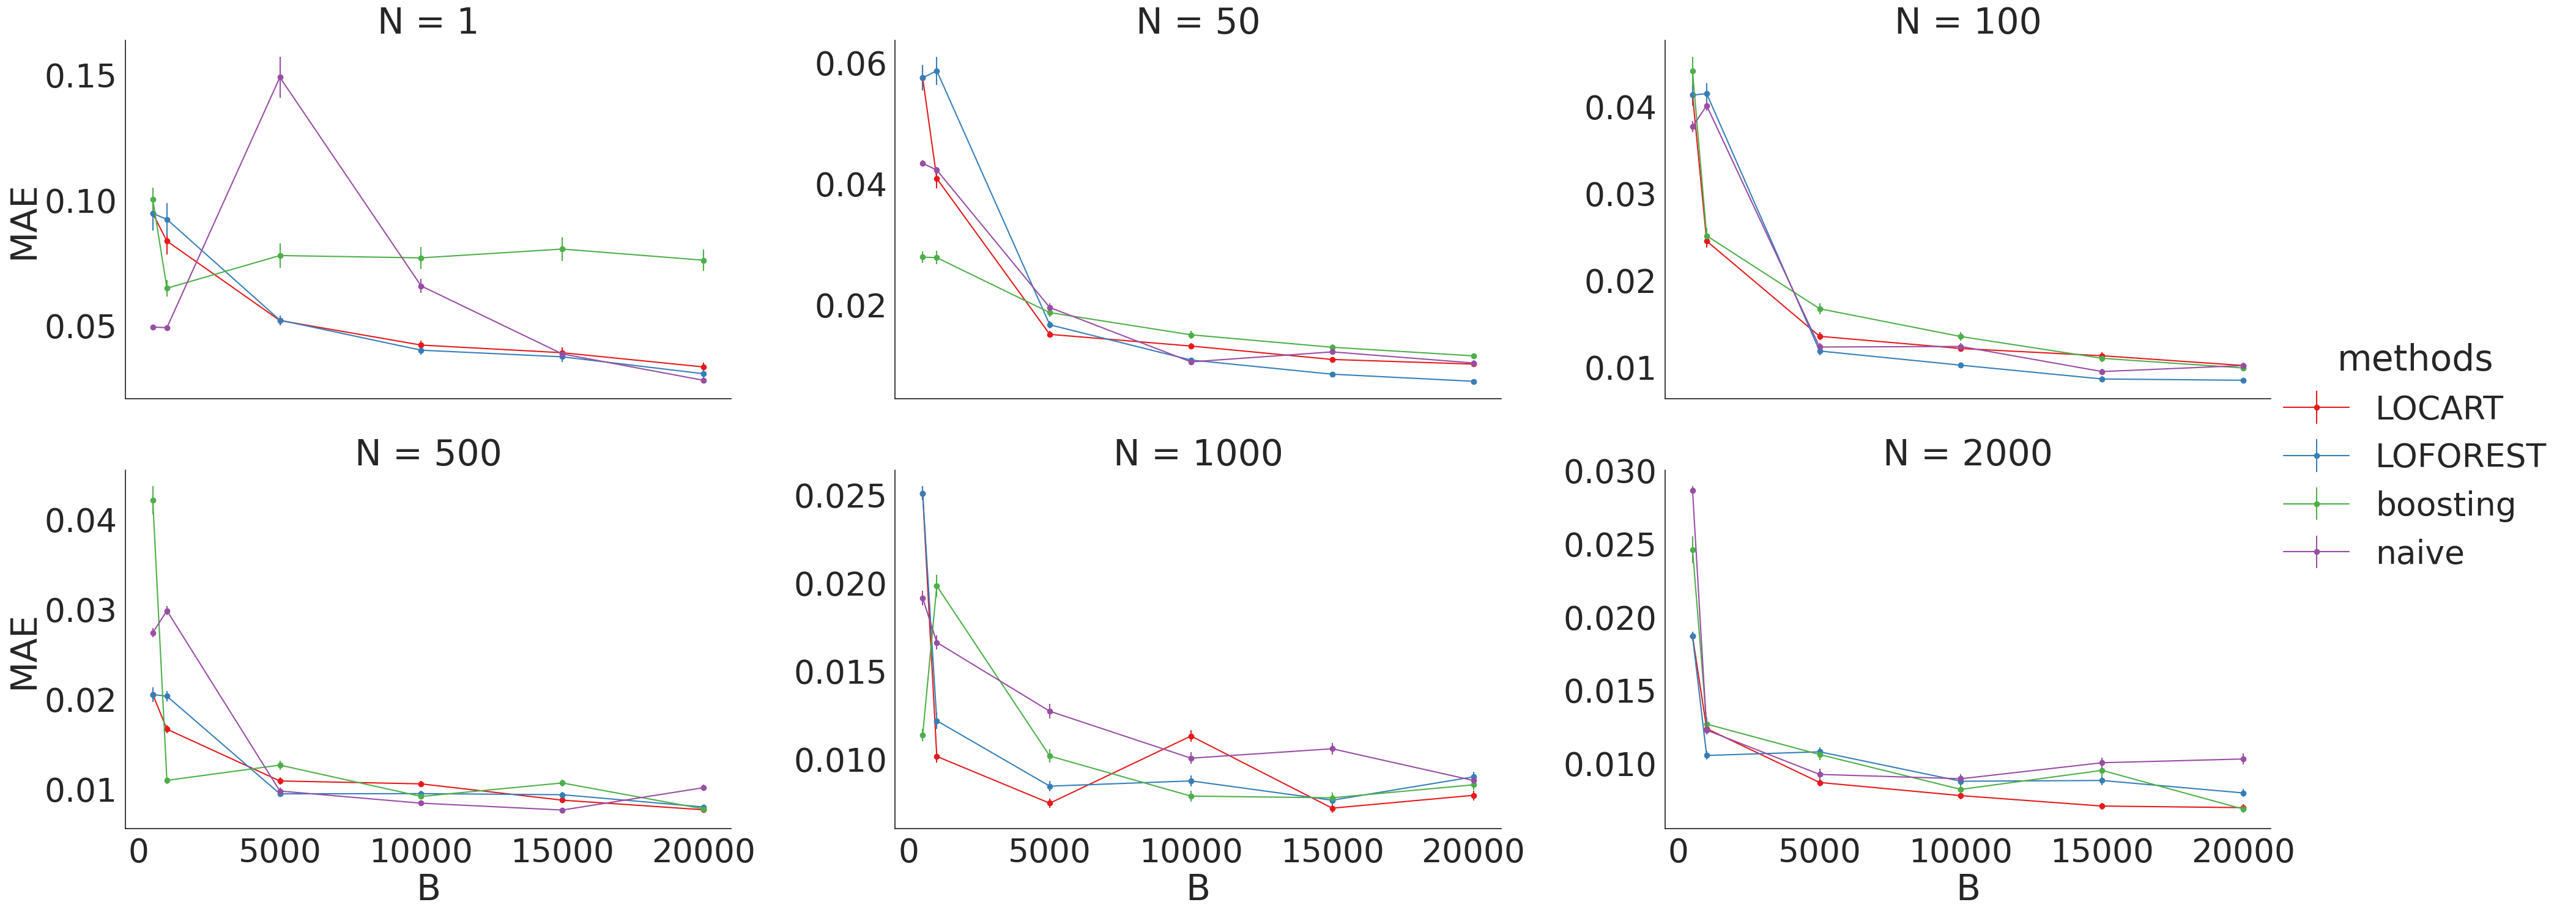

In [23]:
# | echo: false
# Create a line plot with error bars
sns.set(style="white", font_scale=3.5)
g = sns.FacetGrid(
    mae_stats,
    col="N",
    col_wrap=3,
    height=8,
    aspect=1.60,
    hue="methods",
    palette="Set1",
    margin_titles=True,
    sharey=False,
)
g.map(plt.errorbar, "B", "MAE", "se", marker="o", fmt="-o")
g.add_legend()

# Show the plot
plt.show()

# Changing K

In [6]:
n_out = 750
thetas = np.linspace(-4.999, 4.999, n_out)



K_s = range(30, 90, 5)
cov_5000 = dict()

for k in K_s:

    cov_5000[k] = evaluate_coverage_N(
        thetas,
        B=5000,
        N=np.array([10, 100, 1000, 2000]),
        naive_n=500,
        min_samples_leaf=300,
        n=2000,
        seed=1250,
        K = k,
    )
    print(f"Done for K = {k}")

Computing coverage for each N:   0%|          | 0/4 [00:00<?, ?it/s]

Computing coverage for each N: 100%|██████████| 4/4 [03:15<00:00, 48.97s/it]


Done for K = 30


Computing coverage for each N: 100%|██████████| 4/4 [03:16<00:00, 49.03s/it]


Done for K = 35


Computing coverage for each N: 100%|██████████| 4/4 [03:17<00:00, 49.49s/it]


Done for K = 40


Computing coverage for each N: 100%|██████████| 4/4 [03:16<00:00, 49.24s/it]


Done for K = 45


Computing coverage for each N: 100%|██████████| 4/4 [03:19<00:00, 49.96s/it]


Done for K = 50


Computing coverage for each N: 100%|██████████| 4/4 [03:25<00:00, 51.27s/it]


Done for K = 55


Computing coverage for each N: 100%|██████████| 4/4 [03:18<00:00, 49.63s/it]


Done for K = 60


Computing coverage for each N: 100%|██████████| 4/4 [03:23<00:00, 50.84s/it]


Done for K = 65


Computing coverage for each N: 100%|██████████| 4/4 [03:16<00:00, 49.03s/it]


Done for K = 70


Computing coverage for each N: 100%|██████████| 4/4 [03:18<00:00, 49.71s/it]


Done for K = 75


Computing coverage for each N: 100%|██████████| 4/4 [03:17<00:00, 49.37s/it]


Done for K = 80


Computing coverage for each N:  50%|█████     | 2/4 [01:38<01:38, 49.26s/it]


ValueError: Quantiles must be in the range [0, 1]

In [17]:
keys

array(['80'], dtype=object)

/var/folders/4c/6zndblvs3slbw1n6pypvjv4h0000gn/T/ipykernel_30379/1527593528.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["keys"] = data["methods"].apply(lambda x: x.split(" ")[1])
/var/folders/4c/6zndblvs3slbw1n6pypvjv4h0000gn/T/ipykernel_30379/1527593528.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["keys"] = data["methods"].apply(lambda x: x.split(" ")[1])
/var/folders/4c/6zndblvs3slbw1n6pypvjv4h0000gn/T/ipykernel_30379/1527593528.py:10: SettingWithCopyWarning: 
A value is trying 

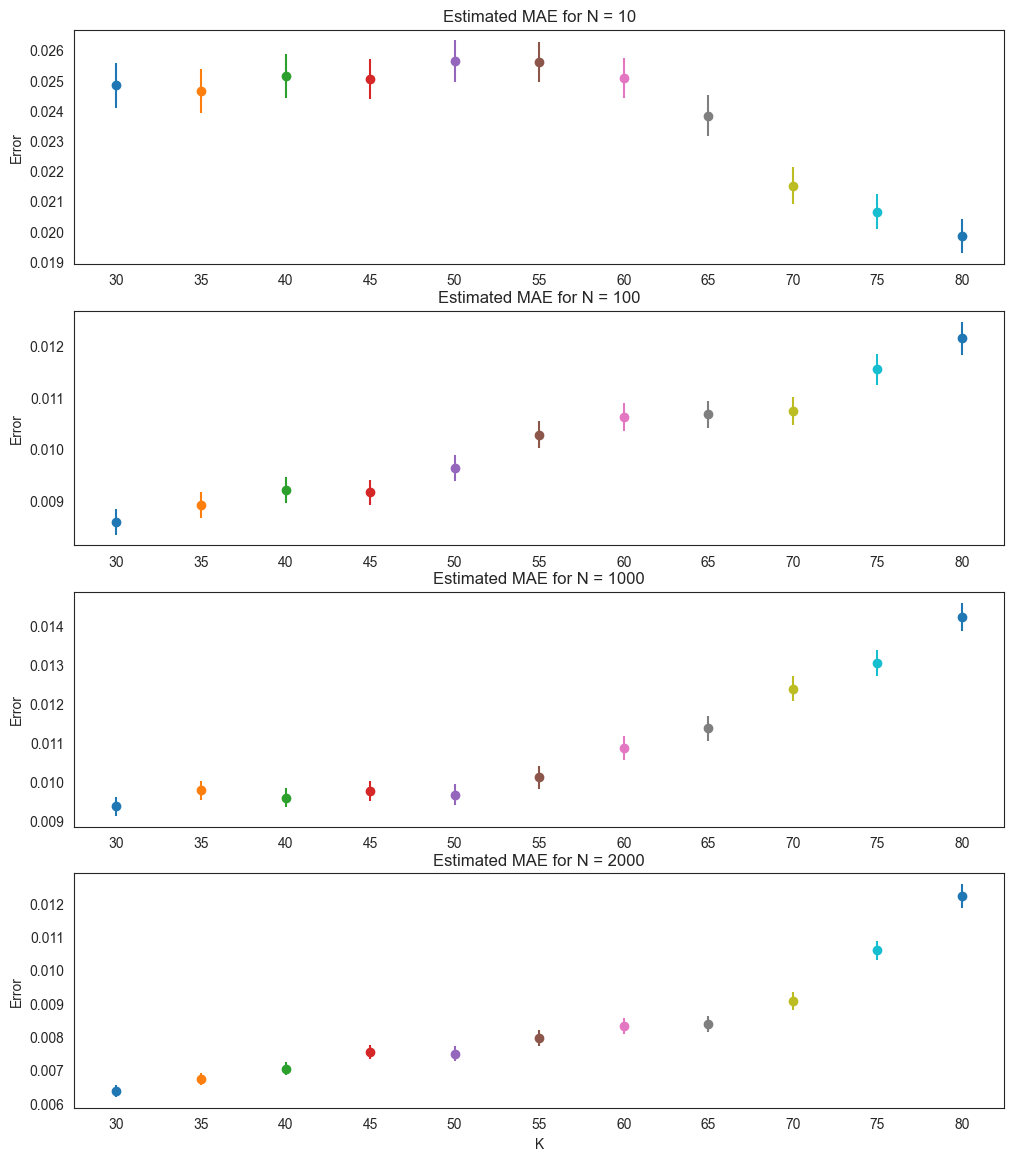

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(12, 14))

for k in range(30, 85, 5):  # Corrected range for k

    for i, N in enumerate([10, 100, 1000, 2000]):
        data = cov_5000[k][0].query(f"N == {N} & methods == 'LOFOREST'")
        data.loc[(data["N"] == N) & (data["methods"] == "LOFOREST"), "methods"] = f"LOFOREST {k}"
        data["keys"] = data["methods"].apply(lambda x: x.split(" ")[1])
        keys = data.iloc[:, 4].values
        mae = data.iloc[:, 2].values
        std_err = data.iloc[:, 3].values
        ax[i].errorbar(keys, mae, yerr=std_err, fmt="o", label=f"K = {k}")  # Plotting the data
        #ax[i].set_xticks(list(range(30, 85, 5)))  # Setting x-ticks
        ax[i].set_ylabel("Error")  # Labeling y-axis
        ax[i].set_title(f"Estimated MAE for N = {N}")  # Setting subplot titles

ax[3].set_xlabel("K")  # Labeling x-axis for the last subplot
#ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adding legend
plt.savefig("simple_bff_K_experiment.pdf", format="pdf", bbox_inches="tight")  # Saving plot to PDF
plt.show()  # Displaying the plot
